# ——  基于电商产品评论数据情感分析  ——

### 1.案例简介

    1、利用文本挖掘技术，对碎片化、非结构化的电商网站评论数据进行清洗与处理，转化为结构化数据。
    2、参考知网发布的情感分析用词语集，统计评论数据的正负情感指数，然后进行情感分析,通过词云图直观查看正负评论的关键词。
    3、比较“机器挖掘的正负情感”与“人工打标签的正负情感”，精度达到88%。
    4、采用LDA主题模型提取评论关键信息，以了解用户的需求、意见、购买原因、产品的优缺点等。
 

### 2.框架

    工具准备
    
    一、导入数据
    二、数据预处理
        （一）去重
        （二）数据清洗
        （三）分词、词性标注、去除停用词、词云图
    三、模型构建
        （一）决策树
        （二）情感分析
        （三）基于LDA模型的主题分析

## 工具准备

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import style #自定义图表风格
style.use('ggplot')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams['font.sans-serif'] = ['Simhei'] # 解决中文乱码问题

import re
import jieba.posseg as psg
import itertools
#conda install -c anaconda gensim
from gensim import corpora,models #主题挖掘，提取关键信息

# pip install wordcloud
from wordcloud import WordCloud,ImageColorGenerator
from collections import Counter

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import graphviz

#### 注意

    以下方法，是为了帮助我们直观查看对象处理的结果。是辅助代码，非必要代码！
    .head()
    print()
    len()
    .shape
    .unique()

## 一、导入数据

In [4]:
raw_data=pd.read_csv('reviews.csv')
raw_data.head()

,content,creationTime,nickname,referenceName,content_type
0,东西收到这么久，都忘了去好评，美的大品牌，值得信赖，东西整体来看，个人感觉还不错，没有出现什...,2017-04-17 13:01:54,鑫***辰,美的（Midea）60升预约洗浴 无线遥控 电热水器 F60-15WB5(Y),pos
1,安装师傅很给力，热水器也好用，感谢美的。,2017-04-17 10:45:33,切***药,美的（Midea）60升预约洗浴 无线遥控 电热水器 F60-15WB5(Y),pos
2,还没安装，基本满意,2017-04-17 10:58:33,j***x,美的（Midea）60升预约洗浴 无线遥控 电热水器 F60-15WB5(Y),pos
3,电热水器收到了，京东自营商品就是好，发货速度快，品质有保障，安装效果好，宝贝非常喜欢，冬天可...,2017-10-18 20:22:33,j***2,美的（Midea）60升预约洗浴 无线遥控 电热水器 F60-15WB5(Y),pos
4,用了几次才来评价，对产品非常满意，加热快保温时间长，售后服务特别好，主动打电话询问送货情况帮...,2017-04-17 09:19:16,j***6,美的（Midea）60升预约洗浴 无线遥控 电热水器 F60-15WB5(Y),pos


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   content        2000 non-null   object
 1   creationTime   2000 non-null   object
 2   nickname       2000 non-null   object
 3   referenceName  2000 non-null   object
 4   content_type   2000 non-null   object
dtypes: object(5)
memory usage: 78.2+ KB


In [6]:
raw_data.columns

Index(['content', 'creationTime', 'nickname', 'referenceName', 'content_type'], dtype='object')

In [10]:
#取值分布
for cate in ['creationTime', 'nickname', 'referenceName', 'content_type']:
    raw_data[cate].value_counts()

2016-06-20 16:03:00    2
2016-06-24 22:35:42    2
2015-06-25 17:36:36    2
2016-06-24 17:42:26    2
2017-10-03 17:13:17    1
                      ..
2017-09-19 14:04:58    1
2017-10-10 16:37:10    1
2016-12-22 12:26:01    1
2017-10-23 12:31:21    1
2017-10-16 14:22:20    1
Name: creationTime, Length: 1996, dtype: int64

j***1    34
j***6    30
j***2    25
j***b    25
j***8    23
         ..
2***m     1
m***2     1
枯树木鱼      1
小***晟     1
城***佬     1
Name: nickname, Length: 1190, dtype: int64

美的（Midea）60升预约洗浴 无线遥控 电热水器 F60-15WB5(Y)    2000
Name: referenceName, dtype: int64

neg    1000
pos    1000
Name: content_type, dtype: int64

## 二、数据预处理

### （一）去重

删除系统自动为客户做出的评论。

In [11]:
reviews=raw_data.copy()
reviews=reviews[['content', 'content_type']]
print('去重之前：',reviews.shape[0])
reviews=reviews.drop_duplicates()
print('去重之后：',reviews.shape[0])

去重之前： 2000
去重之后： 1974


### （二）数据清洗

In [12]:
# 清洗之前
content=reviews['content']
for i in range(5,10):
    print(content[i])
    print('-----------')

物美价廉啊，特别划算的，而且加热速度快。家里用着不错特别方便
-----------
价格合理，配置挺高，物美价值
-----------
老师按装是快的，装修中。没试。希望是正常的！
-----------
五分是习惯
送的快，装的也快，很好，不过装修进行中，为了吊顶只装了热水器，其它后话吧。
我也是醉了，热水器遥控器没电池，还是安装哥车里有一个备用的给装上了。
要赠送的电动牙刷，空气净化器等待配送中&hellip;&hellip;。
一天时间冰箱降100、洗衣机降40、热水器降100、小厨宝降30、烟灶套降100。不过客服说上报解决，电话通知等待中&hellip;&hellip;
-----------
安装的小哥非常好，工作很尽心，我们家是老房子，安装比一般家要费力。安装的非常不错。因为整栋楼要用热水，裙子只能这样装。给小哥点个赞。热水器已经买二个了，一如既往地好用。美的大品牌，质量非常好
-----------


In [13]:
#清洗之后，将数字、字母、京东美的电热水器字样都删除
info=re.compile('[0-9a-zA-Z]|京东|美的|电热水器|热水器|')
content=content.apply(lambda x: info.sub('',x))  #替换所有匹配项

for i in range(5,10):
    print(content[i])
    print('-----------')

物美价廉啊，特别划算的，而且加热速度快。家里用着不错特别方便
-----------
价格合理，配置挺高，物美价值
-----------
老师按装是快的，装修中。没试。希望是正常的！
-----------
五分是习惯
送的快，装的也快，很好，不过装修进行中，为了吊顶只装了，其它后话吧。
我也是醉了，遥控器没电池，还是安装哥车里有一个备用的给装上了。
要赠送的电动牙刷，空气净化器等待配送中&;&;。
一天时间冰箱降、洗衣机降、降、小厨宝降、烟灶套降。不过客服说上报解决，电话通知等待中&;&;
-----------
安装的小哥非常好，工作很尽心，我们家是老房子，安装比一般家要费力。安装的非常不错。因为整栋楼要用热水，裙子只能这样装。给小哥点个赞。已经买二个了，一如既往地好用。大品牌，质量非常好
-----------


### （三）分词、词性标注、去除停用词、词云图

(1)分词

目标
   
    输入：
    - content、content_type
    - 共有1974条评论句子
    输出：
    - 构造DF，包含： 分词、对应词性、分词所在原句子的id、分词所在原句子的content_type
    - 共有6万多行
    
    非结构化数据——>结构化数据
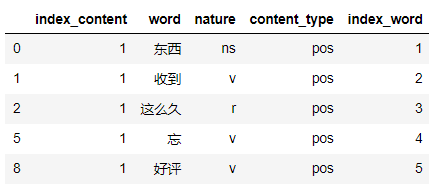

In [14]:
#分词，由元组组成的list
seg_content=content.apply( lambda s:  [(x.word,x.flag) for x in psg.cut(s)] )  

seg_content.shape
len(seg_content)
print(seg_content[5])

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\user\AppData\Local\Temp\jieba.cache
Loading model cost 0.715 seconds.
Prefix dict has been built successfully.


(1974,)

1974

[('物美价廉', 'l'), ('啊', 'zg'), ('，', 'x'), ('特别', 'd'), ('划算', 'v'), ('的', 'uj'), ('，', 'x'), ('而且', 'c'), ('加热', 'v'), ('速度', 'n'), ('快', 'a'), ('。', 'x'), ('家里', 's'), ('用', 'p'), ('着', 'uz'), ('不错', 'a'), ('特别', 'd'), ('方便', 'a')]


In [15]:
#统计评论词数
n_word=seg_content.apply(lambda s: len(s))

len(n_word)
n_word.head(6)

1974

0    32
1    11
2     6
3    39
4    44
5    18
Name: content, dtype: int64

In [16]:
#得到各分词在第几条评论
n_content=[ [x+1]*y for x,y in zip(list(seg_content.index),list(n_word))] #[x+1]*y,表示复制y份，由list组成的list
index_content_long=sum(n_content,[]) #表示去掉[]，拉平,返回list
len(index_content_long)

63794

In [17]:
sum([[2,2],[3,3,3]],[])

[2, 2, 3, 3, 3]

In [18]:
#分词及词性，去掉[]，拉平
seg_content.head()

seg_content_long=sum(seg_content,[])

seg_content_long

type(seg_content_long)
len(seg_content_long)

0    [(东西, ns), (收到, v), (这么久, r), (，, x), (都, d), ...
1    [(安装, v), (师傅, nr), (很, d), (给, p), (力, n), (，...
2    [(还, d), (没, v), (安装, v), (，, x), (基本, n), (满意...
3    [(收到, v), (了, ul), (，, x), (自营, vn), (商品, n), ...
4    [(用, p), (了, ul), (几次, m), (才, d), (来, v), (评价...
Name: content, dtype: object

[('东西', 'ns'),
 ('收到', 'v'),
 ('这么久', 'r'),
 ('，', 'x'),
 ('都', 'd'),
 ('忘', 'v'),
 ('了', 'ul'),
 ('去', 'v'),
 ('好评', 'v'),
 ('，', 'x'),
 ('大', 'a'),
 ('品牌', 'n'),
 ('，', 'x'),
 ('值得', 'v'),
 ('信赖', 'n'),
 ('，', 'x'),
 ('东西', 'ns'),
 ('整体', 'n'),
 ('来看', 'u'),
 ('，', 'x'),
 ('个人感觉', 'n'),
 ('还', 'd'),
 ('不错', 'a'),
 ('，', 'x'),
 ('没有', 'v'),
 ('出现', 'v'),
 ('什么', 'r'),
 ('问题', 'n'),
 ('，', 'x'),
 ('值得', 'v'),
 ('拥有', 'v'),
 ('！', 'x'),
 ('安装', 'v'),
 ('师傅', 'nr'),
 ('很', 'd'),
 ('给', 'p'),
 ('力', 'n'),
 ('，', 'x'),
 ('也好', 'y'),
 ('用', 'p'),
 ('，', 'x'),
 ('感谢', 'v'),
 ('。', 'x'),
 ('还', 'd'),
 ('没', 'v'),
 ('安装', 'v'),
 ('，', 'x'),
 ('基本', 'n'),
 ('满意', 'v'),
 ('收到', 'v'),
 ('了', 'ul'),
 ('，', 'x'),
 ('自营', 'vn'),
 ('商品', 'n'),
 ('就是', 'd'),
 ('好', 'a'),
 ('，', 'x'),
 ('发货', 'n'),
 ('速度', 'n'),
 ('快', 'a'),
 ('，', 'x'),
 ('品质', 'n'),
 ('有', 'v'),
 ('保障', 'v'),
 ('，', 'x'),
 ('安装', 'v'),
 ('效果', 'n'),
 ('好', 'a'),
 ('，', 'x'),
 ('宝贝', 'nr'),
 ('非常', 'd'),
 ('喜欢', 'v'),
 ('，', 'x'),
 ('

list

63794

In [19]:
seg_content_long[0]

('东西', 'ns')

In [20]:
#得到加长版的分词、词性
word_long=[x[0] for x in seg_content_long]
nature_long=[x[1] for x in seg_content_long]

len(word_long)
len(nature_long)

63794

63794

In [21]:
#content_type拉长
n_content_type=[ [x]*y for x,y in zip(list(reviews['content_type']),list(n_word))] #[x+1]*y,表示复制y份
content_type_long=sum(n_content_type,[]) #表示去掉[]，拉平

len(content_type_long)

63794

In [22]:
review_long=pd.DataFrame({'index_content':index_content_long,
                        'word':word_long,
                        'nature':nature_long,
                        'content_type':content_type_long})
review_long.shape
review_long.head()

(63794, 4)

,index_content,word,nature,content_type
0,1,东西,ns,pos
1,1,收到,v,pos
2,1,这么久,r,pos
3,1,，,x,pos
4,1,都,d,pos


（2）去除标点符号、去除停用词

In [23]:
review_long['nature'].unique()

array(['ns', 'v', 'r', 'x', 'd', 'ul', 'a', 'n', 'u', 'nr', 'p', 'y',
       'vn', 't', 'c', 'm', 'l', 'b', 'i', 'uj', 'zg', 's', 'uz', 'nz',
       'f', 'uv', 'ad', 'q', 'j', 'g', 'ud', 'an', 'nrt', 'vg', 'ng', 'k',
       'o', 'mq', 'df', 'e', 'vd', 'z', 'nt', 'tg', 'rz', 'ug', 'yg', 'h',
       'vq', 'ag', 'rr'], dtype=object)

In [24]:
#去除标点符号
review_long_clean=review_long[review_long['nature']!='x'] #x表示标点符合
review_long_clean.shape

(51436, 4)

In [26]:
#导入停用词
stop_path=open('stoplist.txt','r',encoding='UTF-8')
stop_words=stop_path.readlines()

len(stop_words)
stop_words[0:5]

5748

['\ufeff \n', '说\n', '人\n', '元\n', 'hellip\n']

In [27]:
#停用词，预处理
stop_words=[word.strip('\n') for word in stop_words]
stop_words[0:5]

['\ufeff ', '说', '人', '元', 'hellip']

In [28]:
#得到不含停用词的分词表
word_long_clean=list(set(word_long)-set(stop_words))
len(word_long_clean)

review_long_clean=review_long_clean[review_long_clean['word'].isin(word_long_clean)]
review_long_clean.shape

4455

(25172, 4)

(3)在原df中，再增加一列，该分词在本条评论的位置

In [29]:
#再次统计每条评论的分词数量
n_word=review_long_clean.groupby('index_content').count()['word']
n_word

index_word=[ list(np.arange(1,x+1)) for x in list(n_word)] 
index_word_long=sum(index_word,[]) #表示去掉[]，拉平

len(index_word_long)

index_content
1       14
2        4
3        2
4       20
5       23
        ..
1996     6
1997    20
1998     3
1999    10
2000     4
Name: word, Length: 1964, dtype: int64

25172

In [30]:
review_long_clean['index_word']=index_word_long
review_long_clean.head()

,index_content,word,nature,content_type,index_word
0,1,东西,ns,pos,1
1,1,收到,v,pos,2
2,1,这么久,r,pos,3
5,1,忘,v,pos,4
8,1,好评,v,pos,5


In [32]:
review_long_clean.to_csv('1_review_long_clean.csv')

(4)提取名词

In [33]:
n_review_long_clean=review_long_clean[[ 'n' in nat for nat in review_long_clean.nature]]
n_review_long_clean.shape
n_review_long_clean.head()

(10189, 5)

,index_content,word,nature,content_type,index_word
0,1,东西,ns,pos,1
11,1,品牌,n,pos,6
14,1,信赖,n,pos,8
16,1,东西,ns,pos,9
17,1,整体,n,pos,10


In [34]:
n_review_long_clean.nature.value_counts()
n_review_long_clean.to_csv('1_n_review_long_clean.csv')

n      8086
nr      724
vn      699
ns      416
nz      136
ng       60
nrt      36
an       25
nt        7
Name: nature, dtype: int64

（5）词云图

In [35]:
#txt = "life is short, you need python"
#review_long_clean.word.values.dtype
#print("okok+"+review_long_clean.word.values.dtype)
##print("okok+"+review_long_clean.word.values)
#wordcloud.generate(Counter(review_long_clean.word.values))
#wordcloud.generate_from_frequencies(Counter(review_long_clean.word.values))
#wordcloud.to_file('ct.png')

C:\ProgramData\Anaconda3\lib\site-packages\wordcloud\wordcloud.py:996: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0"


<Figure size 1440x720 with 0 Axes>

(-0.5, 733.5, 614.5, -0.5)

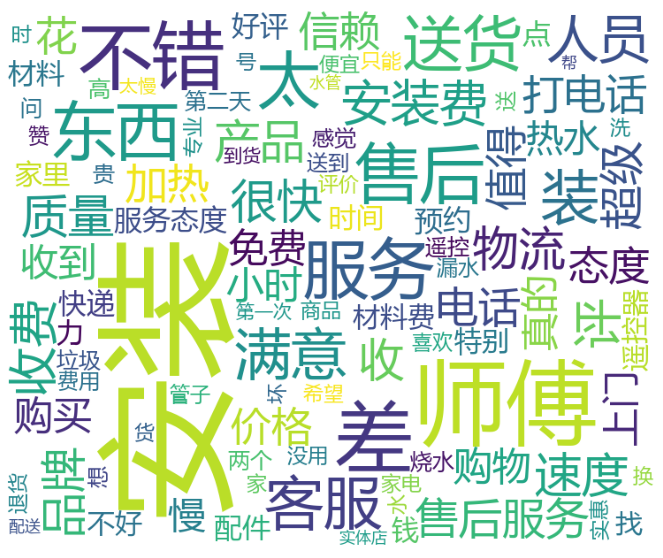

In [36]:
#font=r"C:\Windows\Fonts\msyh.ttc"
font=r"C:\Windows\Fonts\msyh.ttc"

background_image=plt.imread('1.png')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) 
#wordcloud = WordCloud(font_path=font, max_words = 100, background_color='white',mask=background_image) #width=1600,height=1200, mode='RGBA'
#wordcloud = WordCloud(font_path=None,max_words = 100, background_color='white', mode='RGBA')
#print("okok+"+review_long_clean.word.values)
wordcloud.generate_from_frequencies(Counter(review_long_clean.word.values))
wordcloud.to_file('1_分词后的词云图.png')

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Figure size 1440x720 with 0 Axes>

(-0.5, 733.5, 614.5, -0.5)

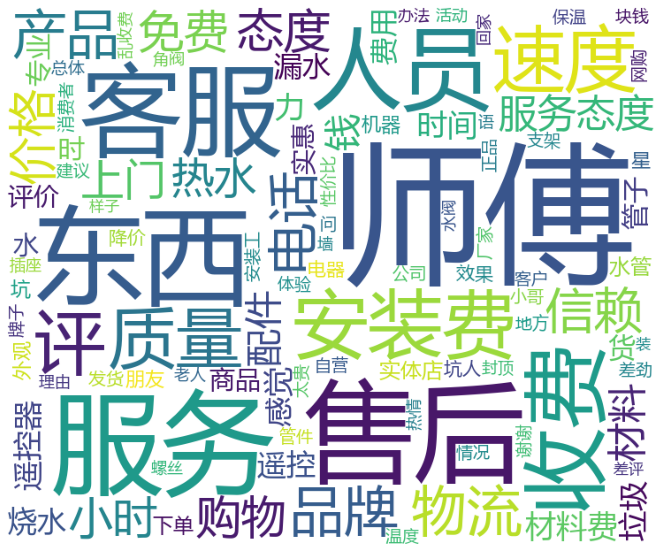

In [38]:
font=r"C:\Windows\Fonts\msyh.ttc"

background_image=plt.imread('1.png')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(n_review_long_clean.word.values))
wordcloud.to_file('1_分词后的词云图(名词）.png')

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 三、模型构建

### （一）基于决策树的情感分类

In [39]:
#第一步：构造特征空间和标签

Y=[]
for ind in review_long_clean.index_content.unique():
    y=[ word for word in review_long_clean.content_type[review_long_clean.index_content==ind].unique() ]
    Y.append(y)
len(Y)

X=[]
for ind in review_long_clean.index_content.unique():
    term=[ word for word in review_long_clean.word[review_long_clean.index_content==ind].values ]
    X.append(' '.join(term))
len(X)

X
Y

1964

1964

['东西 收到 这么久 忘 好评 品牌 值得 信赖 东西 整体 个人感觉 不错 值得 拥有',
 '安装 师傅 力 感谢',
 '安装 满意',
 '收到 自营 商品 发货 速度 品质 保障 安装 效果 宝贝 喜欢 冬天 小时 热水 自营 值得 信赖 值得 推荐 自营',
 '几次 评价 产品 满意 加热 保温 时间 长 售后服务 特别 主动 打电话 询问 送货 情况 帮 安装 非常感谢 售后 大姐 服务 下次 购买',
 '物美价廉 特别 划算 加热 速度 家里 不错 特别',
 '价格合理 配置 高 物美 价值',
 '老师 装 装修 中 试 希望',
 '五分 习惯 送 装 装修 中 吊顶 装 话 醉 遥控器 电池 安装 哥 车里 备用 给装 赠送 电动牙刷 空气 净化器 等待 配送 中 时间 冰箱 降 洗衣机 降 降 小厨 宝降 烟灶 套降 客服 上报 解决 电话 通知 等待 中',
 '安装 小哥 工作 尽心 家 老房子 安装 家 费力 安装 不错 整栋 楼 热水 裙子 只能 装 小哥 点 赞 二个 一如既往 好用 品牌 质量',
 '前 天下 单买 用上 发现 街上 卖 便宜 店家 网上 他家 贵 老板 面 网上',
 '冲着 以内 变频 级 能效 制冷 效果 不错',
 '购物 电器 问 型号 型号 相识 家电 下线 安装 师傅 挺好 加热 很快 购物 满意 走用 安装费 花元 喷头 槊 料 花 伞 安装 麻烦',
 '物流 早上 送来 中午 安装 安装 安装 师傅 负责 效果 售后 确实',
 '满意 价格 产品质量 货运 安装 调试 工作人员 服务态度 售后服务',
 '收费 安装 速度 很快 管道 走 整齐 不错',
 '几天 想 晒 差点 忘 这款 喜欢',
 '安装 没用 不多 做 评价 凑 字',
 '不错 安装 人员 专业 值得 信赖',
 '家里 挺好用 在家 安装 很好',
 '装 太阳能 坏掉 换',
 '真心 感觉 不错 装 当晚 三个 冲凉 热水 没用 好评',
 '真心 不错 喜欢 品牌 赞',
 '安装 希望 没什么',
 '完美 不用 天天 太阳',
 '售后 预约 安装',
 '质量 不错 暖水 挺快 支持',
 '不错 物超所值',
 '凌晨 一点 下单 点 送到 点 员工 上门 安装 速度 效率 扛 扛 特别 赞扬 

[['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],


In [40]:
#第二步：训练集、测试集划分
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=7)

#第三步：词转向量，01矩阵
count_vec=CountVectorizer(binary=True) 
x_train=count_vec.fit_transform(x_train)
x_test=count_vec.transform(x_test)  

#第四步：构建决策树
dtc=tree.DecisionTreeClassifier(max_depth=5)
dtc.fit(x_train,y_train)
print('在训练集上的准确率：%.2f'% accuracy_score(y_train,dtc.predict(x_train)))

y_true=y_test
y_pred=dtc.predict(x_test)
print(classification_report(y_true,y_pred))
print('在测试集上的准确率：%.2f'% accuracy_score(y_true,y_pred))

DecisionTreeClassifier(max_depth=5)

在训练集上的准确率：0.72
              precision    recall  f1-score   support

         neg       0.64      0.96      0.77       197
         pos       0.93      0.44      0.60       196

    accuracy                           0.70       393
   macro avg       0.78      0.70      0.68       393
weighted avg       0.78      0.70      0.68       393

在测试集上的准确率：0.70


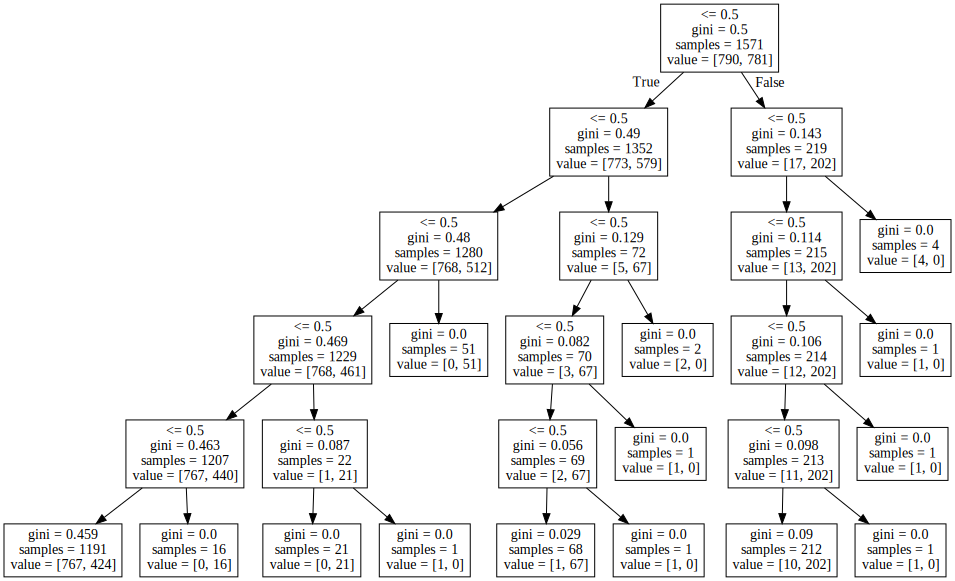

In [44]:
#第五步：画决策树
#这个决策数图，需要在网上下载graphviz  包，并且配置环境变量
from graphviz import Digraph
import os
#C:\\Program Files\\Graphviz\\bin
#C:\\Users\\huangcong\\Desktop\\202203教案\\分享资料3\\1.png
os.environ["PATH"] += os.pathsep + 'F:\\python\\Graphviz\\bin'
dot_data=tree.export_graphviz(dtc ,feature_names=count_vec.get_feature_names())
graph=graphviz.Source(dot_data)
graph

### （二）情感分析

数据预处理的思路与目标

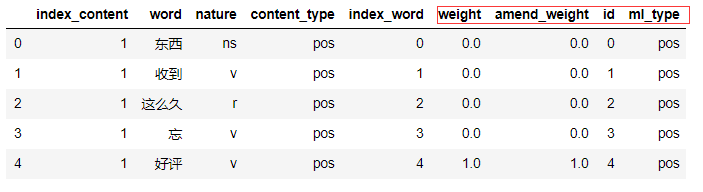

(1)导入评价情感词

In [45]:
#来自知网发布的情感分析用词语集
#raw_data=pd.read_csv('C:\\Users\\huangcong\\Desktop\\202203教案\\分享资料3\\reviews.csv')   注意各路径 \ /
#务必这种写法'C:\\Users\\huangcong\\Desktop\\202203教案\\分享资料3\\正面评价词语（中文）.txt',header=None,sep='/n',engine='python'
pos_comment=pd.read_csv('正面评价词语（中文）.txt',header=None,sep='/n',engine='python') 
neg_comment=pd.read_csv('负面评价词语（中文）.txt',header=None,sep='/n',engine='python')

pos_emotion=pd.read_csv('正面情感词语（中文）.txt',header=None,sep='/n',engine='python')
neg_emotion=pd.read_csv('负面情感词语（中文）.txt',header=None,sep='/n',engine='python')

In [46]:
pos_comment.shape
neg_comment.shape

pos_emotion.shape
neg_emotion.shape

(3743, 1)

(3138, 1)

(833, 1)

(1251, 1)

In [47]:
pos=pd.concat([pos_comment,pos_emotion],axis=0)
pos.shape

neg=pd.concat([neg_comment,neg_emotion],axis=0)
neg.shape

(4576, 1)

(4389, 1)

(2)增加新词

In [48]:
c='点赞'
c in pos.values

d='歇菜'
d in neg.values

False

False

In [49]:
new_pos=pd.Series(['点赞'])
new_neg=pd.Series(['歇菜'])
positive=pd.concat([pos,new_pos],axis=0)
positive.shape

negative=pd.concat([neg,new_neg],axis=0)
negative.shape

(4577, 1)

(4390, 1)

In [50]:
positive.columns=['review']
positive['weight']=pd.Series([1]*len(positive))
positive.head()

,review,weight
0,侻,1
1,俶傥,1
2,僄,1
3,劼,1
4,嫕,1


In [51]:
negative.columns=['review']
negative['weight']=pd.Series([-1]*len(negative))
negative.head()

,review,weight
0,僄,-1
1,啰啰唆唆,-1
2,啰啰嗦嗦,-1
3,啰里啰唆,-1
4,啰里啰嗦,-1


In [52]:
pos_neg=pd.concat([positive,negative],axis=0)
pos_neg.shape

(8967, 2)

(3)合并到review_long_clean中

In [53]:
#表联接

data=review_long_clean.copy()
review_mltype=pd.merge(data,pos_neg,how='left',left_on='word',right_on='review')
review_mltype.shape

review_mltype=review_mltype.drop(['review'],axis=1)
review_mltype=review_mltype.replace(np.nan,0)
review_mltype.head()

(25793, 7)

,index_content,word,nature,content_type,index_word,weight
0,1,东西,ns,pos,1,0.0
1,1,收到,v,pos,2,0.0
2,1,这么久,r,pos,3,0.0
3,1,忘,v,pos,4,0.0
4,1,好评,v,pos,5,1.0


(4)修正情感倾向，

如有多重否定，那么奇数否定是否定，偶数否定是肯定

看该情感词前2个词，来判罚否定的语气。如果在句首，则没有否词，如果在句子的第二次词，则看前1个词，来判断否定的语气。

In [54]:
notdict=pd.read_csv('not.csv')
notdict.shape

notdict['freq']=[1]*len(notdict)
notdict.head()

(21, 1)

,term,freq
0,不,1
1,没,1
2,无,1
3,非,1
4,莫,1


In [55]:
#准备一
review_mltype['amend_weight']=review_mltype['weight']
review_mltype['id']=np.arange(0,review_mltype.shape[0])
review_mltype.head()

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,1,东西,ns,pos,1,0.0,0.0,0
1,1,收到,v,pos,2,0.0,0.0,1
2,1,这么久,r,pos,3,0.0,0.0,2
3,1,忘,v,pos,4,0.0,0.0,3
4,1,好评,v,pos,5,1.0,1.0,4


In [56]:
# 准备二，只保留有情感值的行

only_review_mltype=review_mltype[review_mltype['weight']!=0]
only_review_mltype.index=np.arange(0,only_review_mltype.shape[0]) #索引重置
only_review_mltype.shape
only_review_mltype.head()

(5115, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,1,好评,v,pos,5,1.0,1.0,4
1,1,值得,v,pos,7,1.0,1.0,6
2,1,信赖,n,pos,8,1.0,1.0,7
3,1,不错,a,pos,12,1.0,1.0,11
4,1,值得,v,pos,13,1.0,1.0,12


In [57]:
i=4
review_i=review_mltype[review_mltype['index_content']==only_review_mltype['index_content'][i]]
review_i#第i个情感词的评论

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,1,东西,ns,pos,1,0.0,0.0,0
1,1,收到,v,pos,2,0.0,0.0,1
2,1,这么久,r,pos,3,0.0,0.0,2
3,1,忘,v,pos,4,0.0,0.0,3
4,1,好评,v,pos,5,1.0,1.0,4
5,1,品牌,n,pos,6,0.0,0.0,5
6,1,值得,v,pos,7,1.0,1.0,6
7,1,信赖,n,pos,8,1.0,1.0,7
8,1,东西,ns,pos,9,0.0,0.0,8
9,1,整体,n,pos,10,0.0,0.0,9


In [58]:
#看该情感词前2个词，来判罚否定的语气。如果在句首，则没有否词，如果在句子的第二次词，则看前1个词，来判断否定的语气。

index=only_review_mltype['id']

for i in range(0,only_review_mltype.shape[0]):
    
    review_i=review_mltype[review_mltype['index_content']==only_review_mltype['index_content'][i]] #第i个情感词的评论
    review_i.index=np.arange(0,review_i.shape[0])#重置索引后，索引值等价于index_word
    word_ind = only_review_mltype['index_word'][i] #第i个情感值在该条评论的位置
    
    #第一种，在句首。则不用判断
    #第二种，在评论的第2个为位置
    if word_ind==2:
        ne=sum( [ review_i['word'][word_ind-1] in notdict['term']  ] )
        if ne==1:
            review_mltype['amend_weight'][index[i]] = -( review_mltype['weight'][index[i]] )
    #第三种，在评论的第2个位置以后       
    elif word_ind > 2:
        ne=sum( [ word in notdict['term'] for word in review_i['word'][[word_ind-1,word_ind-2]]  ] ) # 注意用中括号[word_ind-1,word_ind-2]
        if ne==1:
            review_mltype['amend_weight'][index[i]]=- ( review_mltype['weight'][index[i]] )

In [59]:
review_mltype.shape
review_mltype[(review_mltype['weight']-review_mltype['amend_weight'])!=0] #说明两列值一样

(25793, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,id


(5)计算每条评论的情感值

In [60]:
review_mltype.tail()

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
25788,1999,差,a,neg,10,-1.0,-1.0,25788
25789,2000,两个,m,neg,1,0.0,0.0,25789
25790,2000,送到,v,neg,2,0.0,0.0,25790
25791,2000,未,d,neg,3,0.0,0.0,25791
25792,2000,送到,v,neg,4,0.0,0.0,25792


In [61]:
emotion_value=review_mltype.groupby('index_content',as_index=False)['amend_weight'].sum()
emotion_value.head()
emotion_value.to_csv('./1_emotion_value',index=True,header=True)

,index_content,amend_weight
0,1,5.0
1,2,2.0
2,3,2.0
3,4,5.0
4,5,4.0


(6)查看情感分析效果

In [62]:
#每条评论的amend_weight总和不等于零

content_emotion_value=emotion_value.copy()
content_emotion_value.shape
content_emotion_value=content_emotion_value[content_emotion_value['amend_weight']!=0]
content_emotion_value['ml_type']=''
content_emotion_value['ml_type'][content_emotion_value['amend_weight']>0]='pos'
content_emotion_value['ml_type'][content_emotion_value['amend_weight']<0]='neg'

content_emotion_value.shape
content_emotion_value.head()

(1964, 2)

<ipython-input-62-2f057f38fab7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_emotion_value['ml_type'][content_emotion_value['amend_weight']>0]='pos'
<ipython-input-62-2f057f38fab7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_emotion_value['ml_type'][content_emotion_value['amend_weight']<0]='neg'


(1491, 3)

,index_content,amend_weight,ml_type
0,1,5.0,pos
1,2,2.0,pos
2,3,2.0,pos
3,4,5.0,pos
4,5,4.0,pos


In [63]:
#每条评论的amend_weight总和等于零
#这个方法其实不好用，有一半以上的评论区分不出正、负情感。

content_emotion_value0=emotion_value.copy()
content_emotion_value0=content_emotion_value0[content_emotion_value0['amend_weight']==0]
content_emotion_value0.head()

raw_data.content[6]
raw_data.content[7]
raw_data.content[8]

,index_content,amend_weight
19,20,0.0
20,21,0.0
25,26,0.0
33,34,0.0
46,47,0.0


'价格合理，配置挺高，物美价值'

'老师按装是快的，装修中。没试。希望是正常的！'

'五分是习惯\r\n送的快，装的也快，很好，不过装修进行中，为了吊顶只装了热水器，其它后话吧。\r\n我也是醉了，热水器遥控器没电池，还是安装哥车里有一个备用的给装上了。\r\n要赠送的电动牙刷，空气净化器等待配送中&hellip;&hellip;。\r\n一天时间冰箱降100、洗衣机降40、热水器降100、小厨宝降30、烟灶套降100。不过客服说上报解决，电话通知等待中&hellip;&hellip;'

In [64]:
#合并到大表中

content_emotion_value=content_emotion_value.drop(['amend_weight'],axis=1)
review_mltype.shape
review_mltype=pd.merge(review_mltype,content_emotion_value,how='left',left_on='index_content',right_on='index_content')
review_mltype=review_mltype.drop(['id'],axis=1)
review_mltype.shape
review_mltype.head()

review_mltype.to_csv('./1_review_mltype',index=True,header=True)

(25793, 8)

(25793, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,ml_type
0,1,东西,ns,pos,1,0.0,0.0,pos
1,1,收到,v,pos,2,0.0,0.0,pos
2,1,这么久,r,pos,3,0.0,0.0,pos
3,1,忘,v,pos,4,0.0,0.0,pos
4,1,好评,v,pos,5,1.0,1.0,pos


In [65]:
cate=['index_content','content_type','ml_type']
data_type=review_mltype[cate].drop_duplicates()

confusion_matrix=pd.crosstab(data_type['content_type'],data_type['ml_type'],margins=True)
confusion_matrix

ml_type,neg,pos,All
content_type,,,
neg,515,193,708
pos,39,744,783
All,554,937,1491


In [66]:
data=data_type[['content_type','ml_type']]
data=data.dropna(axis=0)
print( classification_report(data['content_type'],data['ml_type']) )

              precision    recall  f1-score   support

         neg       0.93      0.73      0.82       708
         pos       0.79      0.95      0.87       783

    accuracy                           0.84      1491
   macro avg       0.86      0.84      0.84      1491
weighted avg       0.86      0.84      0.84      1491



(7)制作词云图

- 只看情感词

In [67]:
data=review_mltype.copy()
data=data[data['amend_weight']!=0]

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']

C:\ProgramData\Anaconda3\lib\site-packages\wordcloud\wordcloud.py:996: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0"


<Figure size 1080x504 with 0 Axes>

(-0.5, 733.5, 614.5, -0.5)

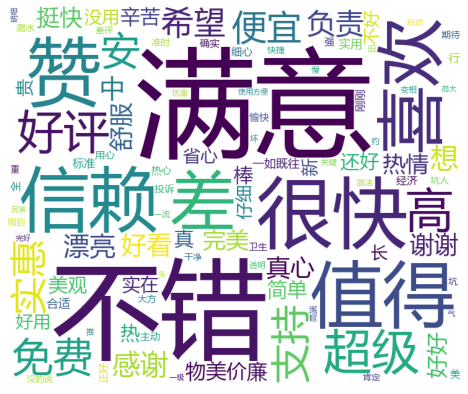

In [68]:

#按照以上修改，显示信息

font=r"C:\Windows\Fonts\msyh.ttc"

background_image=plt.imread('1.png')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
#wordcloud = WordCloud(max_words = 100, mode='RGBA' ,background_color='white') #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_pos.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Figure size 1080x504 with 0 Axes>

(-0.5, 733.5, 614.5, -0.5)

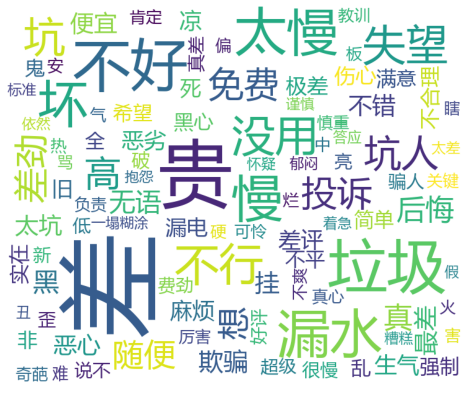

In [69]:
#font=r"C:\Windows\Fonts\msyh.ttc"
font=r"C:\Windows\Fonts\msyh.ttc"

background_image=plt.imread('1.png')
#background_image=plt.imread('./p6sad.jpg')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
#wordcloud = WordCloud(max_words = 100, mode='RGBA' ,background_color='white') #width=1600,height=1200

wordcloud.generate_from_frequencies(Counter(word_data_neg.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

- 看所有词

<Figure size 1080x504 with 0 Axes>

(-0.5, 733.5, 614.5, -0.5)

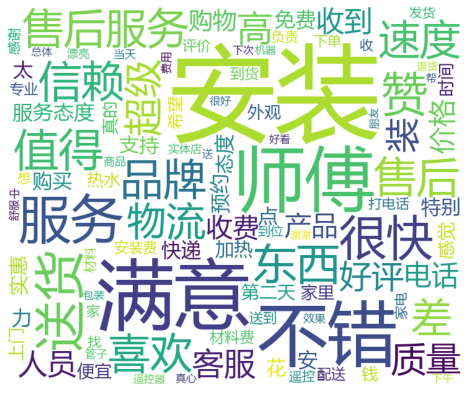

<Figure size 1080x504 with 0 Axes>

(-0.5, 733.5, 614.5, -0.5)

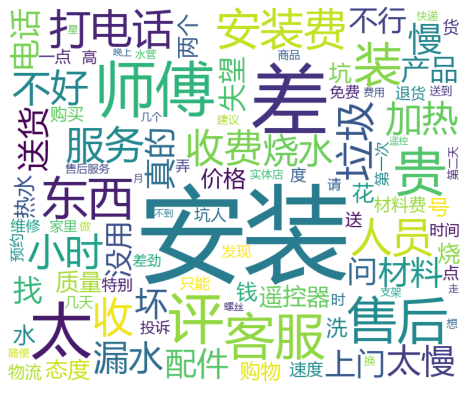

In [70]:
data=review_mltype.copy()

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']

font=r"C:\Windows\Fonts\msyh.ttc"

background_image=plt.imread('1.png')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_pos.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

background_image=plt.imread('1.png')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_neg.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### （三）基于LDA模型的主题分析

优点：不需要人工调试，用相对少的迭代找到最优的主题结构。

（1）建立词典、语料库

In [71]:
data=review_mltype.copy()

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']

In [72]:
#建立词典，去重

pos_dict=corpora.Dictionary([ [i] for i in word_data_pos.word]) #shape=(n,1)
neg_dict=corpora.Dictionary([ [i] for i in word_data_neg.word])

In [73]:
print(pos_dict)

Dictionary(2648 unique tokens: ['东西', '收到', '这么久', '忘', '好评']...)


In [74]:
#建立语料库

pos_corpus=[ pos_dict.doc2bow(j) for j in [ [i] for i in word_data_pos.word] ] #shape=(n,(2,1))
neg_corpus=[ neg_dict.doc2bow(j) for j in [ [i] for i in word_data_neg.word] ]

In [75]:
len(word_data_pos.word)
len(pos_dict)
len(pos_corpus)
pos_corpus  #元素是元组，元组（x,y),x是在词典中的位置，y是1表示存在。

12499

2648

12499

[[(0, 1)],
 [(1, 1)],
 [(2, 1)],
 [(3, 1)],
 [(4, 1)],
 [(5, 1)],
 [(6, 1)],
 [(7, 1)],
 [(0, 1)],
 [(8, 1)],
 [(9, 1)],
 [(10, 1)],
 [(6, 1)],
 [(11, 1)],
 [(12, 1)],
 [(13, 1)],
 [(14, 1)],
 [(15, 1)],
 [(15, 1)],
 [(12, 1)],
 [(16, 1)],
 [(16, 1)],
 [(1, 1)],
 [(17, 1)],
 [(18, 1)],
 [(19, 1)],
 [(20, 1)],
 [(21, 1)],
 [(22, 1)],
 [(12, 1)],
 [(23, 1)],
 [(24, 1)],
 [(25, 1)],
 [(25, 1)],
 [(26, 1)],
 [(27, 1)],
 [(28, 1)],
 [(17, 1)],
 [(6, 1)],
 [(7, 1)],
 [(6, 1)],
 [(29, 1)],
 [(17, 1)],
 [(30, 1)],
 [(31, 1)],
 [(32, 1)],
 [(16, 1)],
 [(16, 1)],
 [(33, 1)],
 [(34, 1)],
 [(35, 1)],
 [(36, 1)],
 [(37, 1)],
 [(38, 1)],
 [(39, 1)],
 [(40, 1)],
 [(41, 1)],
 [(42, 1)],
 [(43, 1)],
 [(44, 1)],
 [(12, 1)],
 [(45, 1)],
 [(46, 1)],
 [(47, 1)],
 [(48, 1)],
 [(49, 1)],
 [(50, 1)],
 [(51, 1)],
 [(38, 1)],
 [(52, 1)],
 [(33, 1)],
 [(20, 1)],
 [(53, 1)],
 [(10, 1)],
 [(38, 1)],
 [(54, 1)],
 [(55, 1)],
 [(56, 1)],
 [(56, 1)],
 [(57, 1)],
 [(58, 1)],
 [(59, 1)],
 [(60, 1)],
 [(61, 1)],
 [(62, 1

(2)主题数寻优


In [76]:
#构造主题数寻优函数

def cos(vector1,vector2):
    '''
    函数功能：余玄相似度函数
    '''
    dot_product=0.0
    normA=0.0
    normB=0.0
    for a,b in zip(vector1,vector2):
        dot_product +=a*b
        normA +=a**2
        normB +=b**2
    if normA==0.0 or normB==0.0:
        return None
    else:
        return ( dot_product/((normA*normB)**0.5) )

In [77]:
#主题数寻优
#这个函数可以重复调用，解决其他项目的问题

def LDA_k(x_corpus,x_dict):
    '''
    函数功能：
    '''
    #初始化平均余玄相似度
    mean_similarity=[]
    mean_similarity.append(1)
    
    #循环生成主题并计算主题间相似度
    for i in np.arange(2,11):
        lda=models.LdaModel(x_corpus,num_topics=i,id2word=x_dict) #LDA模型训练
        
        for j in np.arange(i):
            term=lda.show_topics(num_words=50)
        
        #提取各主题词
        top_word=[] #shape=(i,50)
        for k in np.arange(i):
            top_word.append( [''.join(re.findall('"(.*)"',i)) for i in term[k][1].split('+')]) #列出所有词
        
        #构造词频向量
        word=sum(top_word,[]) #列车所有词
        unique_word=set(word) #去重
        
        #构造主题词列表，行表示主题号，列表示各主题词
        mat=[] #shape=(i,len(unique_word))
        for j in np.arange(i):
            top_w=top_word[j]
            mat.append( tuple([ top_w.count(k) for k in unique_word ])) #统计list中元素的频次，返回元组
        
        #两两组合。方法一
        p=list(itertools.permutations(list(np.arange(i)),2)) #返回可迭代对象的所有数学全排列方式。
        y=len(p) # y=i*(i-1)
        top_similarity=[0]
        for w in np.arange(y):
            vector1=mat[p[w][0]]
            vector2=mat[p[w][1]]
            top_similarity.append(cos(vector1,vector2))

#        #两两组合，方法二
#        for x in range(i-1):
#            for y in range(x,i):
            
        #计算平均余玄相似度
        mean_similarity.append(sum(top_similarity)/ y)
    return mean_similarity

In [ ]:
#计算主题平均余玄相似度

pos_k=LDA_k(pos_corpus,pos_dict)
neg_k=LDA_k(neg_corpus,neg_dict)

pos_k
neg_k

In [ ]:
pd.Series(pos_k,index=range(1,11)).plot()
plt.title('正面评论LDA主题数寻优')
plt.show()

In [ ]:
pd.Series(neg_k,index=range(1,11)).plot()
plt.title('负面评论LDA主题数寻优')
plt.show()

In [ ]:
pos_lda=models.LdaModel(pos_corpus,num_topics=2,id2word=pos_dict)
neg_lda=models.LdaModel(neg_corpus,num_topics=2,id2word=neg_dict)

pos_lda.print_topics(num_topics=10)
neg_lda.print_topics(num_topics=10)